In [3]:
### Load pore structure and LB simulation data


import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import pickle
import scipy.io as sio

imageSize = 250

poreImage = np.load('finalSimFile3D_out.npy')
#poreImage = poreImage[0:imageSize, 0:imageSize, 0:250]

velMat = sio.loadmat('velNormOut.mat')
velDataNorm = velMat['velNorm']
# with open('velNorm.pkl', 'rb') as fin :
#     velNorm = pickle.load(fin)

#poreVelocity = np.reshape(poreVelocity, (imageSize, imageSize, imageSize))



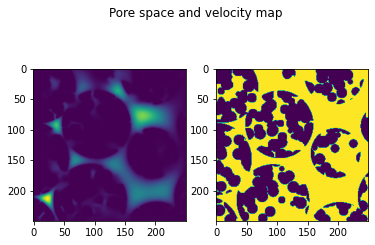

In [4]:
slice = 43

poreImage = np.load('finalSimFile3D_out.npy')
#JUST MIRROR ONE OF THESE
poreImage = np.transpose(poreImage)
#poreImage = np.flip(poreImage, (2,0,1))
#poreImage = np.flipud(poreImage)
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNorm[:,:,slice])
p2.imshow(poreImage[:,:,slice])
#im_3d = ps.visualization.show_3D(velDataNorm)
#plt.imshow(im_3d, cmap=plt.cm.moagma);
#plt.show()


In [25]:
ps.io.to_vtk(velDataNorm,'velVTKOut')
ps.io.to_vtk(poreImage,'poreStructureOut')

In [5]:
snow_output = ps.networks.snow(poreImage,
                               voxel_size=1,
                               boundary_faces=['left','right','front','back','top','bottom'],
                               marching_cubes_area=False)


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1548
Peaks after trimming saddle points:  1005
Peaks after trimming nearby peaks:  983
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 1475/1475 [00:13<00:00, 110.94it/s]


In [17]:
pn = op.network.GenericNetwork()
pn.update(snow_output)
prj = pn.project

# prj.export_data(filename='PNM_extraction', filetype='vtk')
# ps.io.to_vtk(poreImage,path='./poreStructurePSOUT')

In [99]:
snowFilt = ps.filters.snow_partitioning(im=poreImage, return_all=True)
regions = snow.regions*snow.im

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1548
Peaks after trimming saddle points:  1005
Peaks after trimming nearby peaks:  983


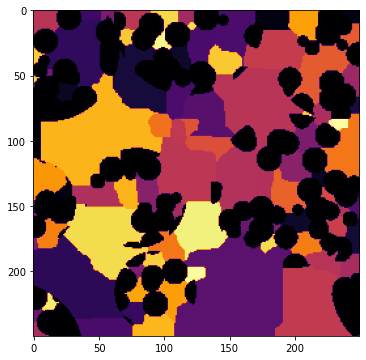

In [139]:
slice = 0
plt.subplots(1, 1, figsize=(6, 6))
fig = plt.imshow(snowFilt.regions[0:imageSize, 0:imageSize, slice], cmap=plt.cm.inferno)

In [140]:
snowFilt.regions[0:imageSize, 0:imageSize, slice]

array([[479, 479, 479, ...,  40,  40,  40],
       [479, 479, 479, ...,  40,  40,  40],
       [479, 479, 479, ...,  40,  40,  40],
       ...,
       [442, 442, 442, ...,   0,   0,   0],
       [442, 442, 442, ...,   0,   0,   0],
       [442, 442, 442, ...,   0,   0, 825]])

In [57]:
# problem snow alg has different dimensions filter is 250, networks to openpnm includes bcs and
# ads a buffer to the array
cubeSize = len(poreImage)

velocities = {}

regionMap = snow_output.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMap[a,b,c])
            if key != '0.0':
                if key in velocities:
                    velocities[key].append(velDataNorm[a,b,c])
                else:
                    velocities.setdefault(key,[])
                    velocities[key].append(velDataNorm[a,b,c])


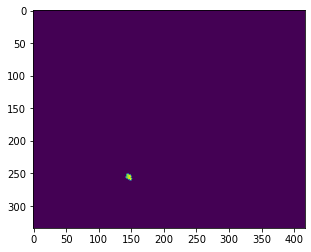

In [150]:
#regionMap[0,:,4]
# pull out individual pore for plotting, after labelling has occurred
testIM = np.where(snow_output.regions == 1,False, True)
test = ps.visualization.show_3D(testIM)
plt.imshow(test)
ps.io.to_vtk(testIM,'pulledOutPore.vtk')

In [15]:
# look up number of regions and specific pore label
print(f"Number of regions: {np.unique(snow_output.regions).size}")
snow_output.regions[6,6,6]

Number of regions: 1476


372

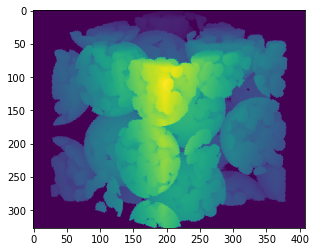

In [133]:
# visualize the entire pore space for reference
test = ps.visualization.show_3D(poreImage)
plt.imshow(test)


In [155]:
np.max(snow_output.regions)

1475

(array([92.,  0., 11., 15.,  9., 13.,  9., 10., 15.,  8., 16., 15., 22.,
        17., 10.,  9.,  1.,  6.,  2.,  2.]),
 array([0.00000e+00, 7.30300e-07, 1.46060e-06, 2.19090e-06, 2.92120e-06,
        3.65150e-06, 4.38180e-06, 5.11210e-06, 5.84240e-06, 6.57270e-06,
        7.30300e-06, 8.03330e-06, 8.76360e-06, 9.49390e-06, 1.02242e-05,
        1.09545e-05, 1.16848e-05, 1.24151e-05, 1.31454e-05, 1.38757e-05,
        1.46060e-05]),
 <BarContainer object of 20 artists>)

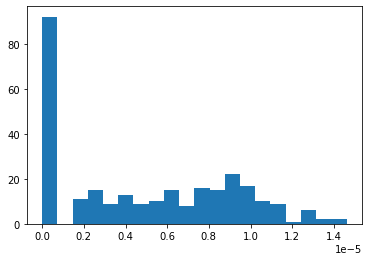

In [24]:
# Plot histogram of pore velocities
poreLabel = '2'
poreVelNorm = velocities.get(poreLabel)

n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
# We can set the number of bins with the `bins` kwarg
plt.hist(poreVelNorm, bins=n_bins)

(array([579., 243., 205., 170., 122.,  70.,  26.,   4.,   5.,   2.,   8.,
         15.,   9.,   7.,   2.,   3.,   0.,   1.,   2.,   2.]),
 array([ 0.26794919,  2.69183509,  5.11572098,  7.53960687,  9.96349276,
        12.38737866, 14.81126455, 17.23515044, 19.65903634, 22.08292223,
        24.50680812, 26.93069401, 29.35457991, 31.7784658 , 34.20235169,
        36.62623758, 39.05012348, 41.47400937, 43.89789526, 46.32178116,
        48.74566705]),
 <BarContainer object of 20 artists>)

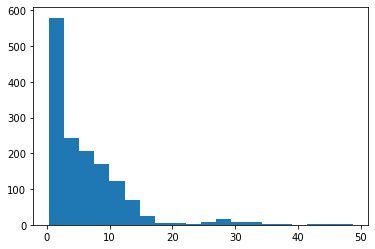

In [30]:
# Plot histogram of pore diameters

poreDiam = pn['pore.diameter']
plt.hist(poreDiam, bins=20)

In [59]:
nRegions = np.unique(snow_output.regions).size
poreDiamVec = np.zeros(nRegions,)
velNormVec = np.zeros(nRegions,)
for a in range(0, nRegions):
    poreDiamVec[a] = pn['pore.diameter'][a]
    velNormVec[a] = np.median(velocities.get(str(a)))

# Current problem is that the velocities dictionary doesn't have a value for label 53 for some reason
# this causes problems here! Fix!
plt.plot(poreDiamVec,velNormVec)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [61]:
a
velocities.get('53')